In [19]:
# !git clone https://github.com/pettepiero/Dial-a-ride.git
# %cd Dial-a-ride/
# !pip install virtualenv
# !virtualenv vrpenv # To set up the env
# !source /content/Dial-a-ride/vrpenv/bin/activate
# !source /content/Dial-a-ride/vrpenv/bin/activate

In [20]:
import copy
import random
from types import SimpleNamespace
from typing import List
import pandas as pd
import vrplib

from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd

from alns import ALNS
from alns.accept import RecordToRecordTravel
from alns.select import *
from alns.stop import MaxIterations


from cvrptw.myvrplib.myvrplib import plot_solution, plot_data, solution_times_statistics, LOGGING_LEVEL
# from cvrptw.myvrplib import plot_solution, plot_data, solution_times_statistics, LOGGING_LEVEL
from cvrptw.myvrplib.data_module import END_OF_DAY, read_solution_format
from cvrptw.myvrplib.data_module import d_data as d_data
from cvrptw.myvrplib.data_module import data as full_data
from cvrptw.myvrplib.route import Route
from cvrptw.myvrplib.vrpstates import CvrptwState
from cvrptw.initial_solutions.initial_solutions import nearest_neighbor_tw, time_neighbours
from cvrptw.operators.destroy import *
from cvrptw.operators.repair import *
from cvrptw.operators.wang_operators import *
from cvrptw.output.analyze_solution import verify_time_windows

In [21]:
%matplotlib inline
SEED = 1234
NUM_ITERATIONS = 100

In [22]:
import logging
logger = logging.getLogger(__name__)
logging.basicConfig(level=LOGGING_LEVEL)

# Implementation of wang 2024
https://www.sciencedirect.com/science/article/pii/S0360835224002432?via%3Dihub

NOTE: data['dimension'] is the number of customers only, not including depots

In [23]:
print(d_data)

          x       y  demand  start_time  end_time  service_time  \
id                                                                
0       NaN     NaN       0          -1        -1           NaN   
1    33.588  30.750       4         157       417          12.0   
2    48.828  65.314      12         190       405           1.0   
3    86.176  59.344       3         223       555           1.0   
4    39.270 -33.057      15         113       306          15.0   
..      ...     ...     ...         ...       ...           ...   
96   52.832  50.684      10         128       448          21.0   
97    6.229  10.590       0           0      1000           0.0   
98   32.663  44.730       0           0      1000           0.0   
99   48.807  48.792       0           0      1000           0.0   
100  33.179  -4.968       0           0      1000           0.0   

     call_in_time_slot route   done   id  
id                                        
0                    3  None  False    0  

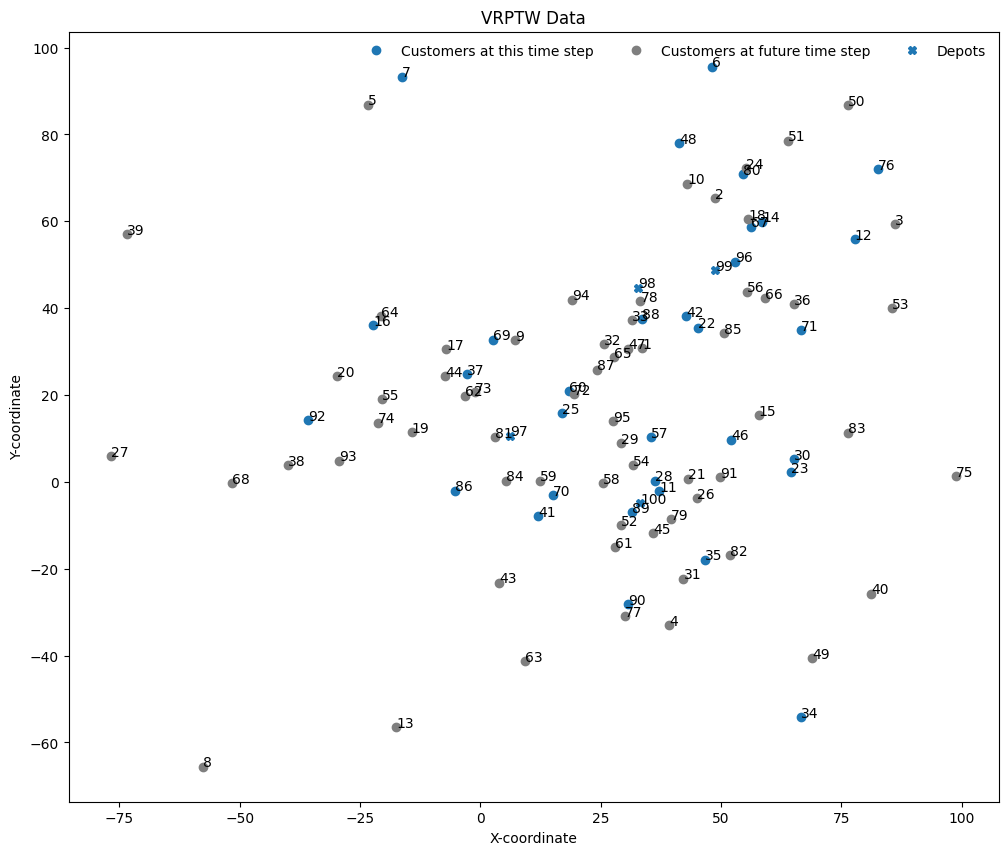

In [24]:
plot_data(d_data, idx_annotations=True, time_step=0)

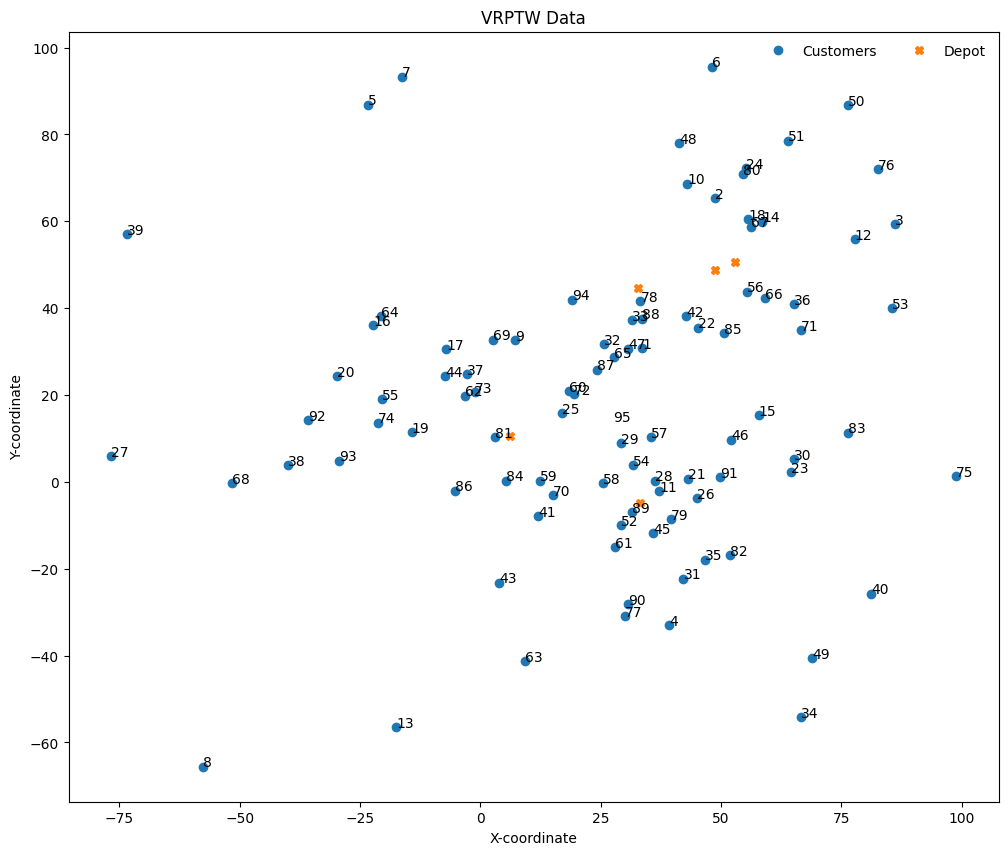

In [25]:
plot_data(data, idx_annotations=True)

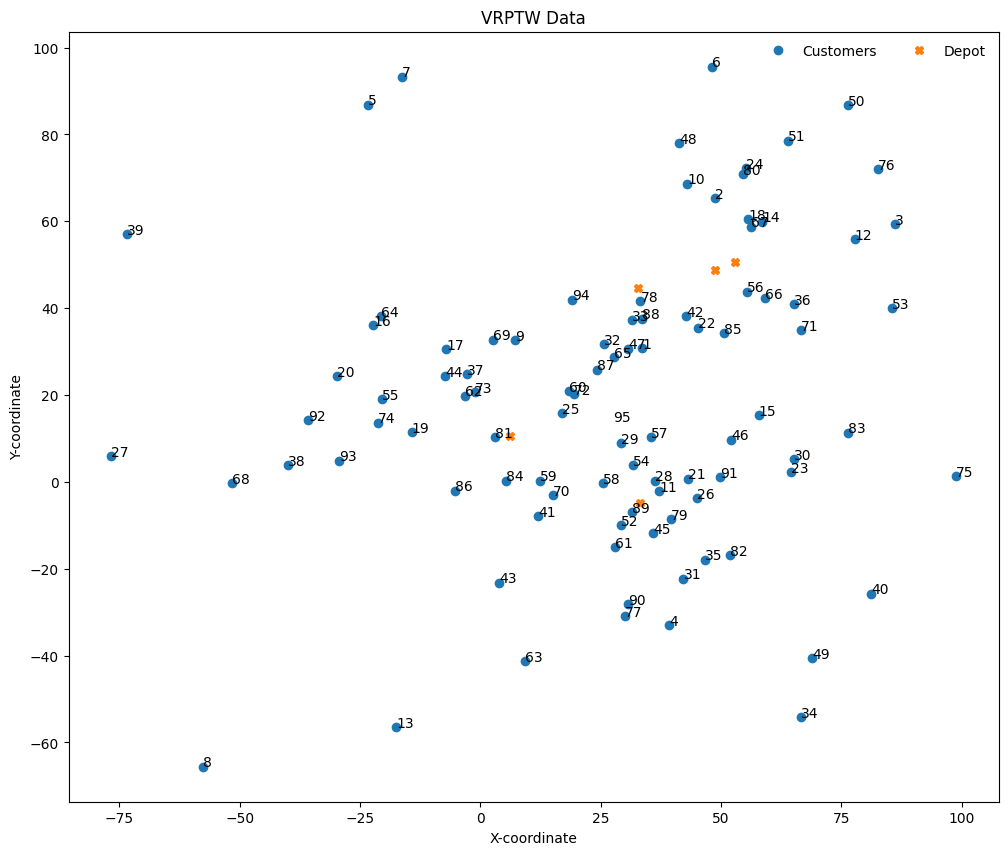

In [26]:
plot_data(full_data, idx_annotations=True)

In [27]:
print(d_data)

          x       y  demand  start_time  end_time  service_time  \
id                                                                
0       NaN     NaN       0          -1        -1           NaN   
1    33.588  30.750       4         157       417          12.0   
2    48.828  65.314      12         190       405           1.0   
3    86.176  59.344       3         223       555           1.0   
4    39.270 -33.057      15         113       306          15.0   
..      ...     ...     ...         ...       ...           ...   
96   52.832  50.684      10         128       448          21.0   
97    6.229  10.590       0           0      1000           0.0   
98   32.663  44.730       0           0      1000           0.0   
99   48.807  48.792       0           0      1000           0.0   
100  33.179  -4.968       0           0      1000           0.0   

     call_in_time_slot route   done   id  
id                                        
0                    3  None  False    0  

## Solution state

In [28]:
def get_customer_info(data, state: CvrptwState, idx: int, cordeau: bool = False):
    """
    Get the customer information for the passed-in index.
    """
    if cordeau:
        if idx == 0:
            print("Error: in Cordeau notation index 0 is a fake customer")
            return
        
    route = state.find_route(idx)
    if route is not None:
        index_in_route = state.find_index_in_route(idx, route)
        route_index = state.routes.index(route)
        print(f"index_in_route: {index_in_route}")
        print(f"route: {route}")

        dict = {
            "index": idx,
            "coords": data["node_coord"][idx],
            "demand": data["demand"][idx].item(),
            "ready time": data["time_window"][idx][0].item(),
            "due time": data["time_window"][idx][1].item(),
            "service_time": data["service_time"][idx].item(),
            "route": route,
        }
    else:
        print(f"Customer {idx} is not in any route")
        dict = {
            "index": idx,
            "coords": data["node_coord"][idx],
            "demand": data["demand"][idx].item(),
            "ready time": data["time_window"][idx][0].item(),
            "due time": data["time_window"][idx][1].item(),
            "service_time": data["service_time"][idx].item(),
            "route": None,
        }
    return dict

## Destroy operators

Destroy operators break parts of a solution down, leaving an incomplete state. This is the first part of each iteration of the ALNS meta-heuristic; the incomplete solution is subsequently repaired by any one repair operator. We will consider one destroy operator: **random removal**. We will also use a separate parameter, the degree of destruction, to control the extent of the damage done to a solution in each step.

In [29]:
degree_of_destruction = 0.05
customers_to_remove = int((data["dimension"] - 1) * degree_of_destruction)
print(f"Removing {customers_to_remove} customers.")

Removing 4 customers.


## Repair operators
We implement a simple, **greedy repair** strategy. It iterates over the set of unassigned customers and finds the best route and index to insert to, i.e., with the least increase in cost. Time window constraints are implemented as follows in the **greedy repair**:

1)  Within the set of unvisited nodes, first find those nodes that can be visited within the node's time window from the current end of each existing route
2)  Add the node that is nearest to the end of some route to that route
3)  If no unvisited nodes can be visited on time, make a new route just for that node

## Initial solution
We need an initial solution that is going to be destroyed and repaired by the ALNS heuristic. To this end, we use a simple *nearest neighbor (NN)* heuristic. NN starts with an empty solution and iteratively adds the nearest customer to the routes. If there are no routes available, then a new route is created.

### Choosing starting depot
If the number of vehicles if larger than number of depots we split the number of vehicles between the depots.

Otherwise, we choose randomly a depot and generate a route from it.
NOTE: maybe performance of the model can be improved by changing the above policy

In [30]:
# calculate_depots(data)
print(data['depot_to_vehicles'])
print(data['vehicle_to_depot'])
print(data['dimension'])

{97: [], 98: [], 99: [0], 100: [1]}
{0: 99, 1: 100}
96


In [31]:
inital_state = CvrptwState(dataset=data)
initial_solution = nearest_neighbor_tw(state=inital_state, initial_time_slot=False)
print(
    initial_solution.nodes_df.loc[initial_solution.nodes_df["call_in_time_slot"] == 0]
)

#Unvisited customers after nearest neighbor solution: 68
Initial solution cost vector: [1032.55  981.2 ]
Initial solution routes: [[99, 46, 27, 19, 13, 94, 6, 83, 78, 65, 23, 32, 75, 43, 82, 60, 88, 99], [100, 85, 44, 40, 29, 87, 51, 95, 4, 90, 92, 73, 18, 96, 14, 68, 56, 100]]
          x       y  demand  start_time  end_time  service_time  \
id                                                                
6    48.132  95.593      20          72       368          12.0   
7   -16.357  93.311      21         157       457          15.0   
11   37.085  -2.112       7         282       626           5.0   
12   77.759  55.817       3         219       569          19.0   
14   58.575  59.888       5         129       430          12.0   
16  -22.327  36.072      21         299       575           8.0   
22   45.184  35.474      24         187       386          16.0   
23   64.484   2.240       8          77       280          18.0   
25   16.925  15.741      19         299       649  

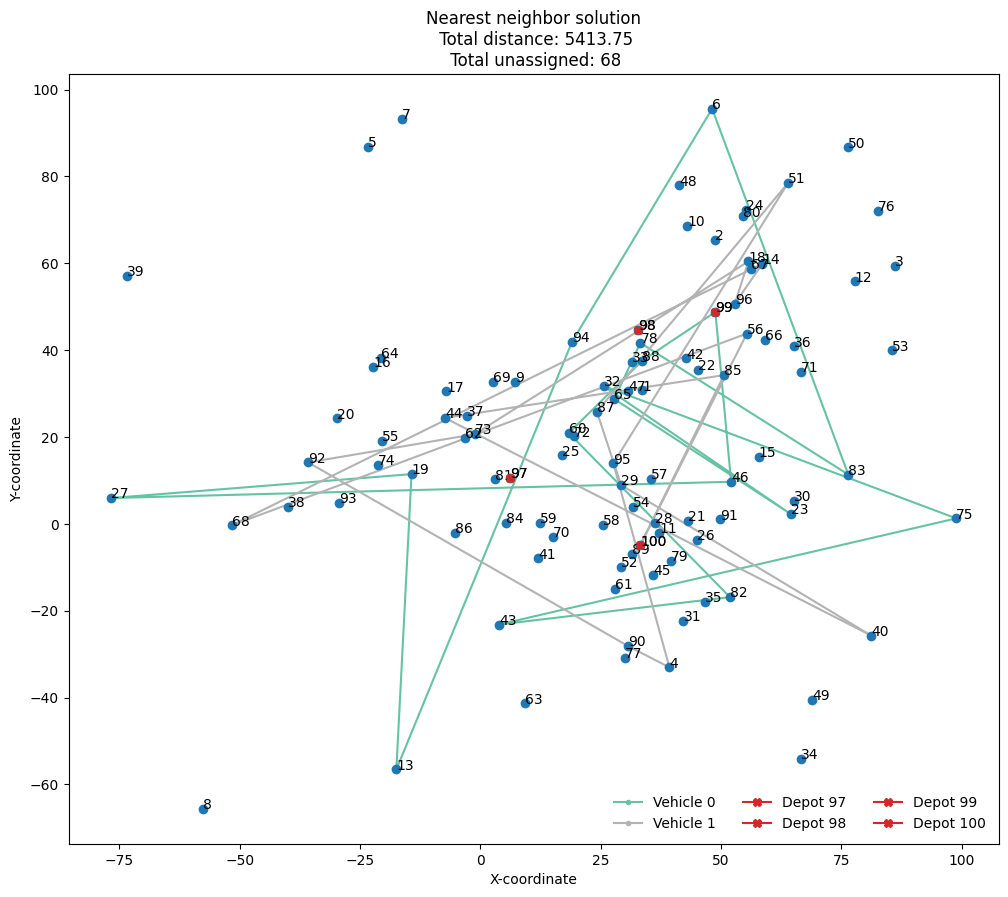

In [32]:
plot_solution(initial_solution, "Nearest neighbor solution", idx_annotations=True)

In [33]:
for route in initial_solution.routes:
    print(route.customers_list)

[99, 46, 27, 19, 13, 94, 6, 83, 78, 65, 23, 32, 75, 43, 82, 60, 88, 99]
[100, 85, 44, 40, 29, 87, 51, 95, 4, 90, 92, 73, 18, 96, 14, 68, 56, 100]


In [34]:
initial_solution_stats = solution_times_statistics(initial_solution)
print(initial_solution_stats)

DEBUG:  6 0 6
DEBUG: [99, 46, 27, 19, 13, 94, 6, 83, 78, 65, 23, 32, 75, 43, 82, 60, 88, 99]
DEBUG: [[0, 0.0], [39.24, 51.24], [180.15, 202.15], [264.87, 266.87], [334.97, 345.97], [451.06, 462.06], [523.06, 535.06], [623.93, 645.93], [698.7, 703.7], [717.72, 721.72], [766.95, 784.95], [833.77, 845.77], [925.12, 936.12], [1034.2, 1048.2], [1096.59, 1102.59], [1153.07, 1161.07], [1183.68, 1205.68], [1224.55, 1224.55]]
DEBUG:  14 1 14
DEBUG: [100, 85, 44, 40, 29, 87, 51, 95, 4, 90, 92, 73, 18, 96, 14, 68, 56, 100]
DEBUG: [[0, 0.0], [42.91, 64.91], [123.7, 147.7], [249.41, 254.41], [316.84, 329.84], [347.47, 372.47], [438.48, 447.48], [521.6, 540.6], [589.02, 604.02], [613.88, 629.88], [708.68, 731.68], [766.88, 785.88], [855.25, 864.25], [874.39, 895.39], [906.24, 918.24], [1043.85, 1064.85], [1180.61, 1190.61], [1244.2, 1244.2]]
DEBUG:  23 0 10
DEBUG: [99, 46, 27, 19, 13, 94, 6, 83, 78, 65, 23, 32, 75, 43, 82, 60, 88, 99]
DEBUG: [[0, 0.0], [39.24, 51.24], [180.15, 202.15], [264.87, 266.

## Heuristic solution

Let's now construct our ALNS heuristic. Since we only have one destroy and repair operator, we do not actually use any adaptive operator selection -- but you can easily add more destroy and repair r_operators. 

In [35]:
# alns = ALNS(rnd.default_rng(SEED))
alns = ALNS(rnd.default_rng())

alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(random_route_removal)
alns.add_destroy_operator(cost_reducing_removal)
alns.add_destroy_operator(worst_removal)

# alns.add_destroy_operator(exchange_reducing_removal)  #to be implemented
# alns.add_destroy_operator(shaw_removal)   #to be implemented

alns.add_repair_operator(greedy_repair_tw)
alns.add_repair_operator(wang_greedy_repair)

In [36]:
num_iterations = NUM_ITERATIONS
inital_state = CvrptwState(dataset=data)
init = nearest_neighbor_tw(state=inital_state, initial_time_slot=False)
select = RouletteWheel([25, 5, 1, 0], 0.8, 4, 2)
# select = RandomSelect(num_destroy=4, num_repair=2)
accept = RecordToRecordTravel.autofit(
    init.objective(), 0.02, 0, num_iterations
)
stop = MaxIterations(num_iterations)
result, destruction_counts, insertion_counts, d_operators_log, r_operators_log = alns.iterate(init, select, accept, stop, data=data, save_plots=False)

#Unvisited customers after nearest neighbor solution: 68
Initial solution cost vector: [1032.55  981.2 ]
Initial solution routes: [[99, 46, 27, 19, 13, 94, 6, 83, 78, 65, 23, 32, 75, 43, 82, 60, 88, 99], [100, 85, 44, 40, 29, 87, 51, 95, 4, 90, 92, 73, 18, 96, 14, 68, 56, 100]]


In [37]:
d_operators = tuple([op[0] for op in alns.destroy_operators])
print(d_operators)
d_ops_dict = {i: op for i, op in enumerate(d_operators)}

('random_removal', 'random_route_removal', 'cost_reducing_removal', 'worst_removal')


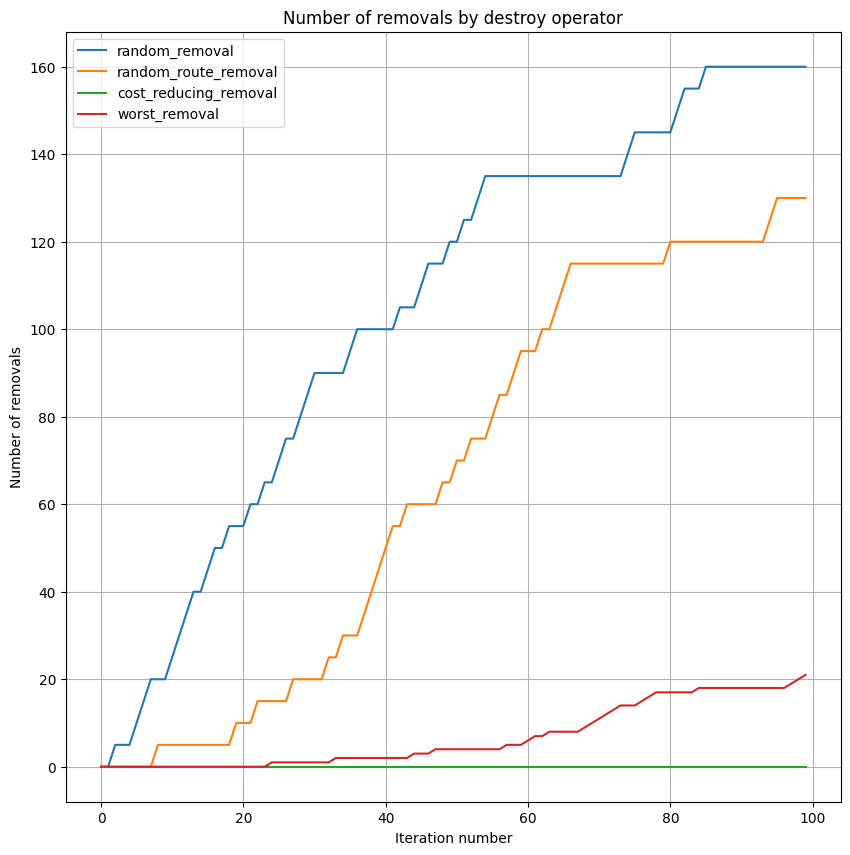

In [38]:
cumulative_sums = np.cumsum(destruction_counts, axis=0)  # Plot each column
rows = np.arange(destruction_counts.shape[0])
fig, ax = plt.subplots(figsize=(10,10))
for col_idx in range(destruction_counts.shape[1]-1):
    plt.plot(rows, cumulative_sums[:, col_idx], label=f"{d_operators[col_idx]}")

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of removals")
plt.title("Number of removals by destroy operator")
plt.legend()
plt.grid(True)
plt.show()

('greedy_repair_tw', 'wang_greedy_repair')


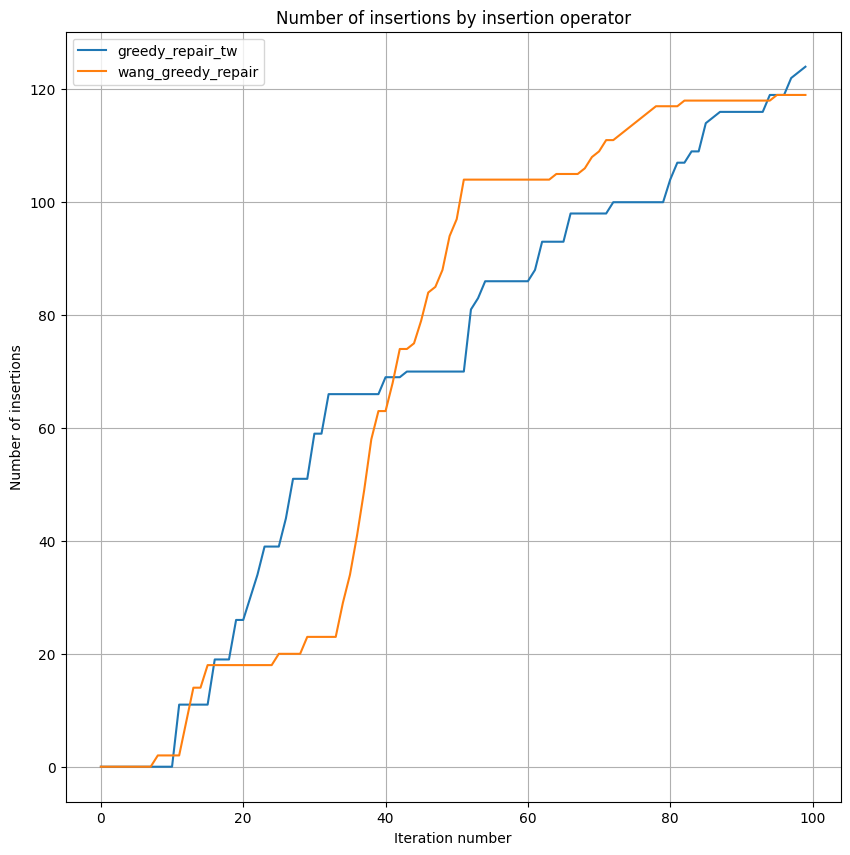

In [39]:
r_operators = tuple([op[0] for op in alns.repair_operators])
r_ops_dict = {i: op for i, op in enumerate(r_operators)}
print(r_operators)
cumulative_sums = np.cumsum(insertion_counts, axis=0)  # Plot each column
rows = np.arange(insertion_counts.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(insertion_counts.shape[1] - 1):
    plt.plot(rows, cumulative_sums[:, col_idx], label=f"{r_operators[col_idx]}")

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of insertions")
plt.title("Number of insertions by insertion operator")
plt.legend()
plt.grid(True)
plt.show()

## Plotting the destroy and repair operators applications

In [40]:
destroy_operators_log_array = np.zeros(shape=(len(d_operators_log), len(d_operators)), dtype=int)
for i, op in enumerate(d_operators_log):
    destroy_operators_log_array[i, op] +=1
destroy_operators_log_array = np.cumsum(destroy_operators_log_array, axis=0)

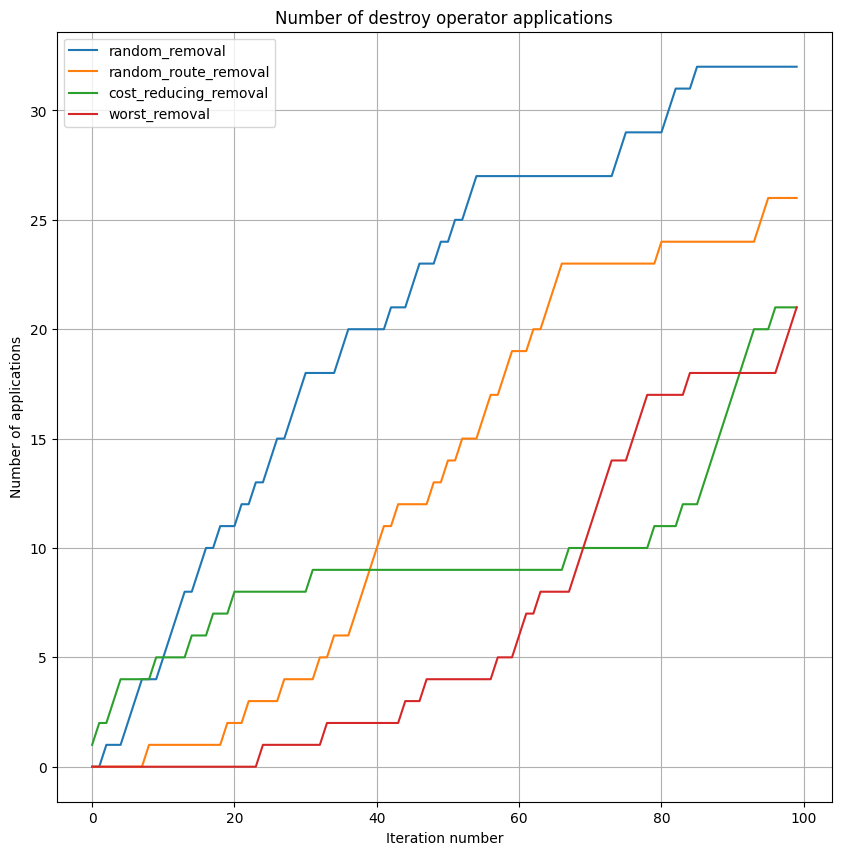

In [41]:
rows = np.arange(destroy_operators_log_array.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(destroy_operators_log_array.shape[1]):
    plt.plot(
        rows, destroy_operators_log_array[:, col_idx], label=f"{d_operators[col_idx]}"
    )

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of applications")
plt.title("Number of destroy operator applications")
plt.legend()
plt.grid(True)
plt.show()

/tmp/ipykernel_108947/518890836.py:8: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


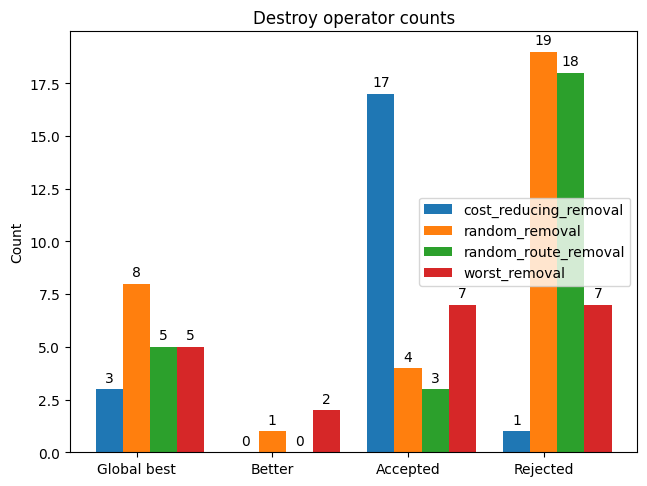

In [42]:
results_df = pd.DataFrame(result.statistics.destroy_operator_counts)
reasons = ["Global best", "Better", "Accepted" , "Rejected"]
x = np.arange(len(reasons))
width = 0.20
multiplier = 0

fig, ax = plt.subplots(layout='constrained')
fig.tight_layout()
for attribute, measurement in results_df.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Count')
ax.set_title('Destroy operator counts')
ax.set_xticks(x + width, reasons)
ax.legend(loc='right', ncols=1)
# ax.set_xlim(0, 4)

plt.show()

In [43]:
repair_operators_log_array = np.zeros(
    shape=(len(r_operators_log), len(r_operators)), dtype=int
)
for i, op in enumerate(r_operators_log):
    repair_operators_log_array[i, op] += 1
repair_operators_log_array = np.cumsum(repair_operators_log_array, axis=0)

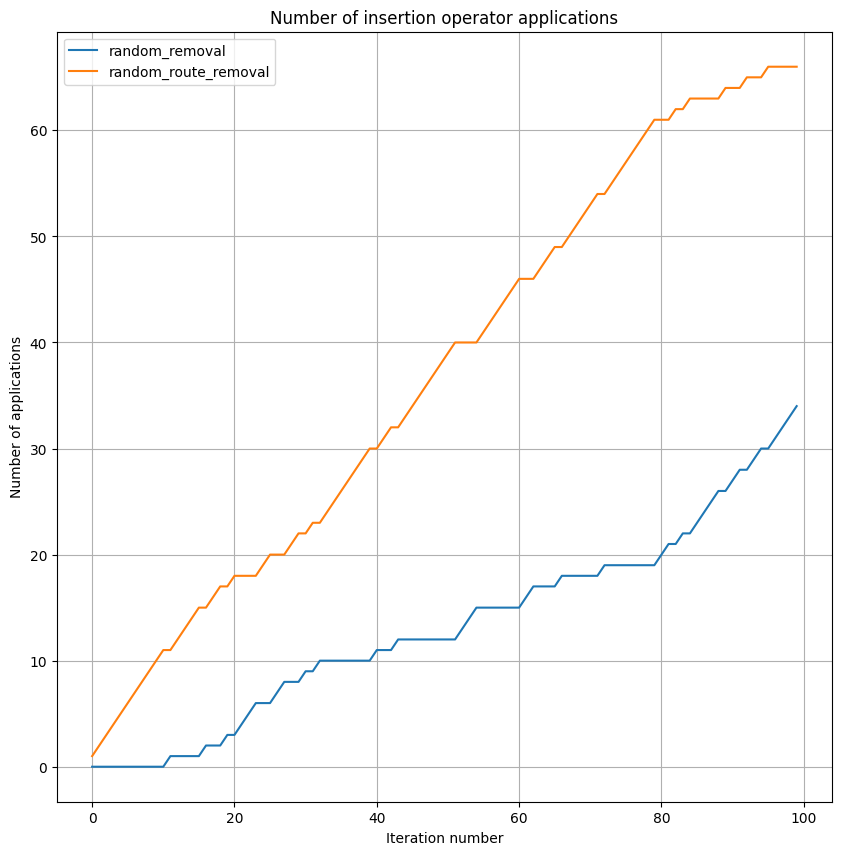

In [44]:
rows = np.arange(repair_operators_log_array.shape[0])
fig, ax = plt.subplots(figsize=(10, 10))
for col_idx in range(repair_operators_log_array.shape[1]):
    plt.plot(
        rows, repair_operators_log_array[:, col_idx], label=f"{d_operators[col_idx]}"
    )

# Customize plot
plt.xlabel("Iteration number")
plt.ylabel("Number of applications")
plt.title("Number of insertion operator applications")
plt.legend()
plt.grid(True)
plt.show()

   wang_greedy_repair  greedy_repair_tw
0                  14                 7
1                   3                 0
2                  23                 8
3                  26                19


(0.0, 4.0)

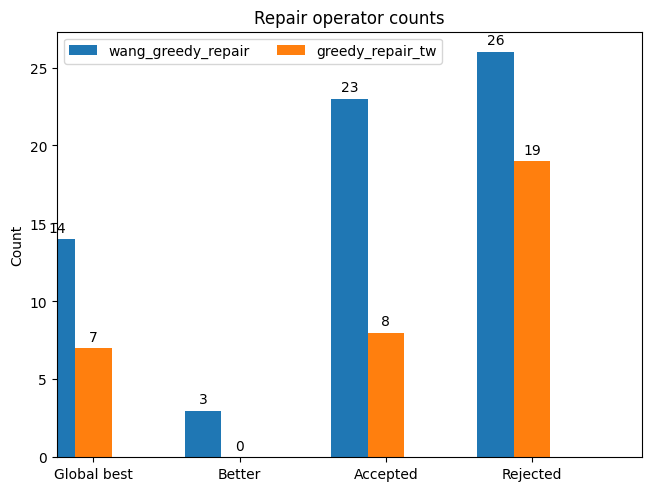

In [45]:
results_df = pd.DataFrame(result.statistics.repair_operator_counts)
print(results_df)

reasons = ["Global best", "Better", "Accepted", "Rejected"]
x = np.arange(len(reasons))
width = 0.25
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for attribute, measurement in results_df.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Count")
ax.set_title("Repair operator counts")
ax.set_xticks(x + width, reasons)
ax.legend(loc="upper left", ncols=4)
ax.set_xlim(0, 4)

## Overall results

In [46]:
solution = result.best_state
objective = solution.objective()
print(f"Best heuristic objective is {objective}.")

Best heuristic objective is 3741.81.


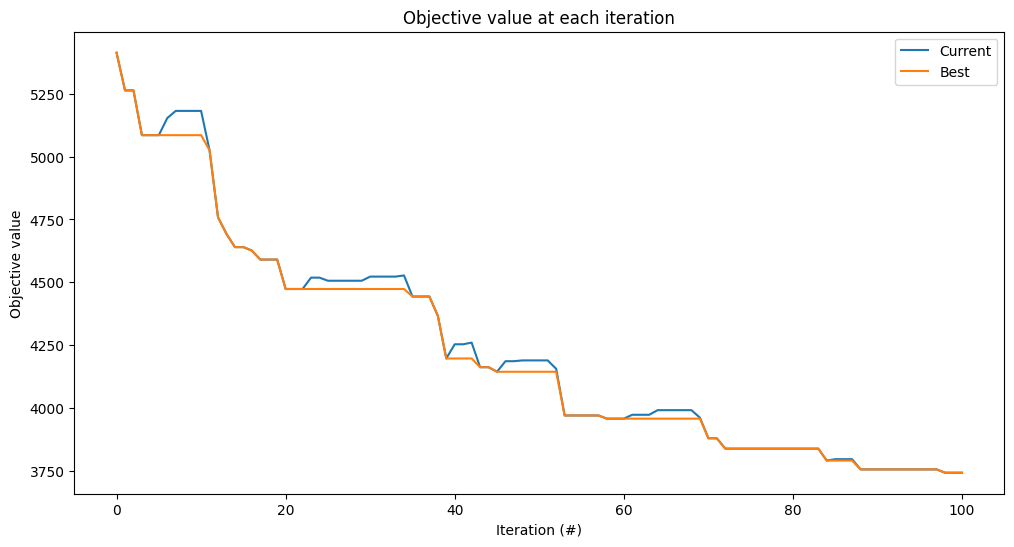

In [47]:
_, ax = plt.subplots(figsize=(12, 6))
result.plot_objectives(ax=ax)

In [48]:
plot_solution(initial_solution, "Nearest-neighbor-solution", save=True, figsize=(8, 8))
plot_solution(solution, "Heuristic-solution", idx_annotations=False, save=True, figsize=(8, 8))

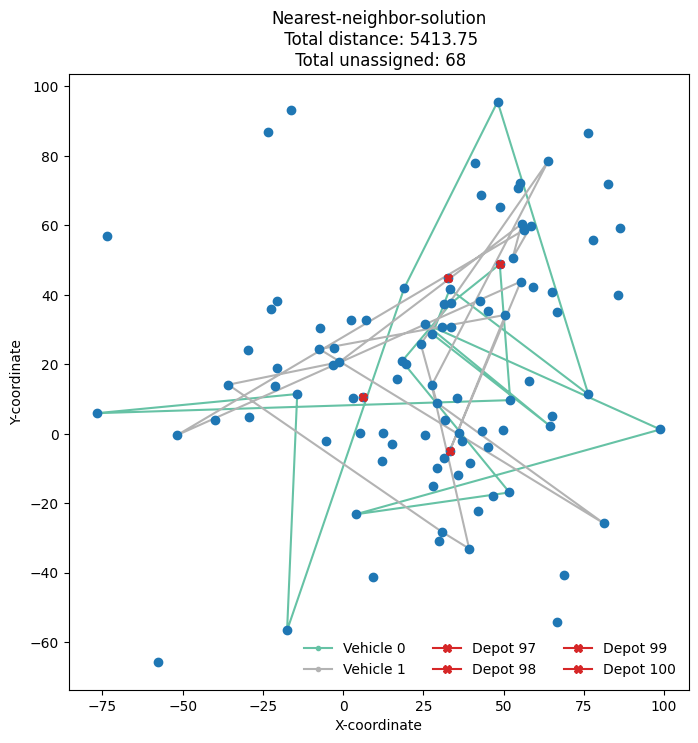

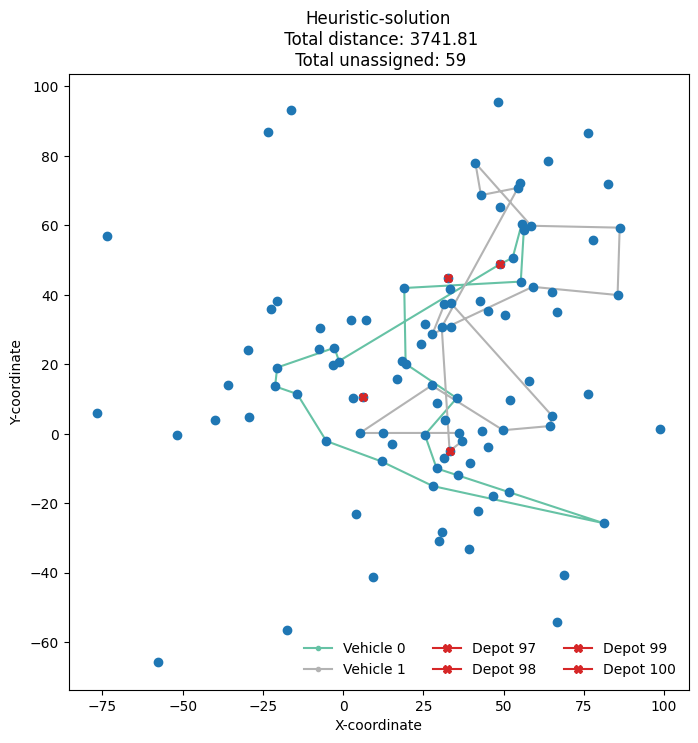

In [49]:
plot_solution(initial_solution, "Nearest-neighbor-solution", save=False, figsize=(8, 8))
plot_solution(solution, "Heuristic-solution", idx_annotations=False, save=False, figsize=(8, 8))

In [50]:
print(f"There are {len(initial_solution.routes)} routes")
served_customers = 0
for route in initial_solution.routes:
    customers = [cust for cust in route.customers_list if cust not in data["depots"]]
    served_customers += len(customers)
    print(route.customers_list)

print(f"Total number of served customers: {served_customers}")


There are 2 routes
[99, 46, 27, 19, 13, 94, 6, 83, 78, 65, 23, 32, 75, 43, 82, 60, 88, 99]
[100, 85, 44, 40, 29, 87, 51, 95, 4, 90, 92, 73, 18, 96, 14, 68, 56, 100]
Total number of served customers: 32


In [51]:
# Calculating the late, early, ontime and left out customers
solution_stats = verify_time_windows(data, initial_solution, percentage=False)
print(solution_stats)

{'total_served': 36, 'early': 2, 'late': 26, 'ontime': 8, 'sum_early': 60.85, 'sum_late': 19263.95}


In [52]:
solution_stats_copy = copy.deepcopy(solution_stats)
del solution_stats_copy["sum_late"]
del solution_stats_copy["sum_early"]
del solution_stats_copy["total_served"]

dict_keys(['early', 'late', 'ontime'])


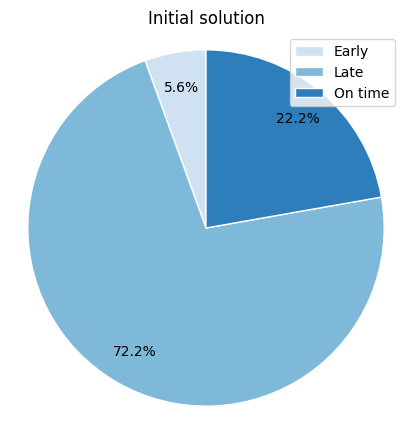

In [53]:
plt.style.use("_mpl-gallery-nogrid")
colors = plt.get_cmap("Blues")(np.linspace(0.2, 0.7, len(solution_stats_copy)))

print(solution_stats_copy.keys())

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(
    solution_stats_copy.values(),
    labels=['Early', 'Late', 'On time'],
    labeldistance=None,
    autopct="%1.1f%%",
    pctdistance=0.8,
    shadow=False,
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    frame=True,
)
ax.set_title("Initial solution")
plt.legend()
plt.axis('off')

plt.show()

In [54]:
print(f"There are {len(solution.routes)} routes")
served_customers = 0
for route in solution.routes:
    customers = [cust for cust in route.customers_list if cust not in data['depots']]
    served_customers += len(customers)
    print(route.customers_list)


print(f"Total number of served customers: {served_customers}")
# Calculating the late, early, ontime and left out customers
solution_stats = verify_time_windows(data, solution, percentage=False)
print(solution_stats)

There are 2 routes
[99, 96, 18, 67, 56, 94, 72, 57, 58, 52, 40, 61, 41, 86, 19, 74, 55, 37, 73, 62, 99]
[100, 11, 28, 59, 84, 95, 91, 23, 30, 88, 33, 65, 66, 53, 3, 14, 48, 10, 80, 47, 100]
Total number of served customers: 38
{'total_served': 42, 'early': 11, 'late': 6, 'ontime': 25, 'sum_early': 1461.6899999999998, 'sum_late': 1955.45}


In [55]:
solution_stats_copy = copy.deepcopy(solution_stats)
del solution_stats_copy["sum_late"]
del solution_stats_copy["sum_early"]
del solution_stats_copy["total_served"]

dict_keys(['early', 'late', 'ontime'])


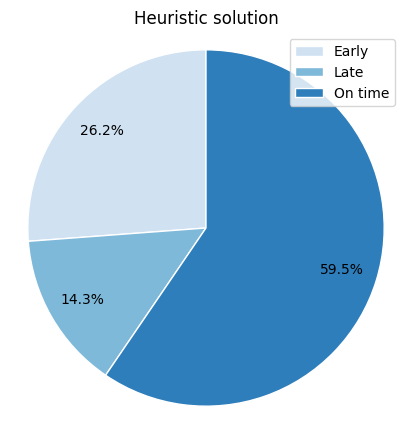

In [56]:
plt.style.use("_mpl-gallery-nogrid")
colors = plt.get_cmap("Blues")(np.linspace(0.2, 0.7, len(solution_stats_copy)))

print(solution_stats_copy.keys())

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(
    solution_stats_copy.values(),
    labels=["Early", "Late", "On time"],
    labeldistance=None,
    autopct="%1.1f%%",
    pctdistance=0.8,
    shadow=False,
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "white", "linewidth": 1},
    frame=True,
)
ax.set_title("Heuristic solution")
plt.legend()
plt.axis('off')

plt.show()

In [57]:
print(solution)
print(initial_solution)

Routes: [[99, 96, 18, 67, 56, 94, 72, 57, 58, 52, 40, 61, 41, 86, 19, 74, 55, 37, 73, 62, 99], [100, 11, 28, 59, 84, 95, 91, 23, 30, 88, 33, 65, 66, 53, 3, 14, 48, 10, 80, 47, 100]], 
Unassigned: [0, 1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 15, 16, 17, 20, 21, 22, 24, 25, 26, 27, 29, 31, 32, 34, 35, 36, 38, 39, 42, 43, 44, 45, 46, 49, 50, 51, 54, 60, 63, 64, 68, 69, 70, 71, 75, 76, 77, 78, 79, 81, 82, 83, 85, 87, 89, 90, 92, 93]
Routes: [[99, 46, 27, 19, 13, 94, 6, 83, 78, 65, 23, 32, 75, 43, 82, 60, 88, 99], [100, 85, 44, 40, 29, 87, 51, 95, 4, 90, 92, 73, 18, 96, 14, 68, 56, 100]], 
Unassigned: [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 15, 16, 17, 20, 21, 22, 24, 25, 26, 28, 30, 31, 33, 34, 35, 36, 37, 38, 39, 41, 42, 45, 47, 48, 49, 50, 52, 53, 54, 55, 57, 58, 59, 61, 62, 63, 64, 66, 67, 69, 70, 71, 72, 74, 76, 77, 79, 80, 81, 84, 86, 89, 91, 93, 97, 98, 99, 100]


### Solution

In [58]:


# Example usage
# data = read_solution_format("path_to_file.txt", print_data=True)

bks = read_solution_format("/home/pettepiero/tirocinio/dial-a-ride/data/c-mdvrptw-sol/pr01.res", print_data=False)

In [59]:
print(bks.keys())
print(len(bks['routes']))

for route in bks["routes"]:
    print(route["customers"])

dict_keys(['solution_cost', 'routes', 'n_vehicles'])
8
[49, 9, 42, 46, 39, 15, 25, 26, 23, 36, 32, 49]
[49, 35, 44, 31, 41, 7, 37, 49]
[50, 34, 10, 45, 6, 27, 3, 48, 11, 50]
[50, 22, 50]
[51, 28, 4, 19, 14, 1, 16, 51]
[51, 13, 33, 20, 29, 8, 5, 17, 18, 51]
[52, 30, 52]
[52, 2, 47, 24, 12, 38, 40, 21, 43, 52]


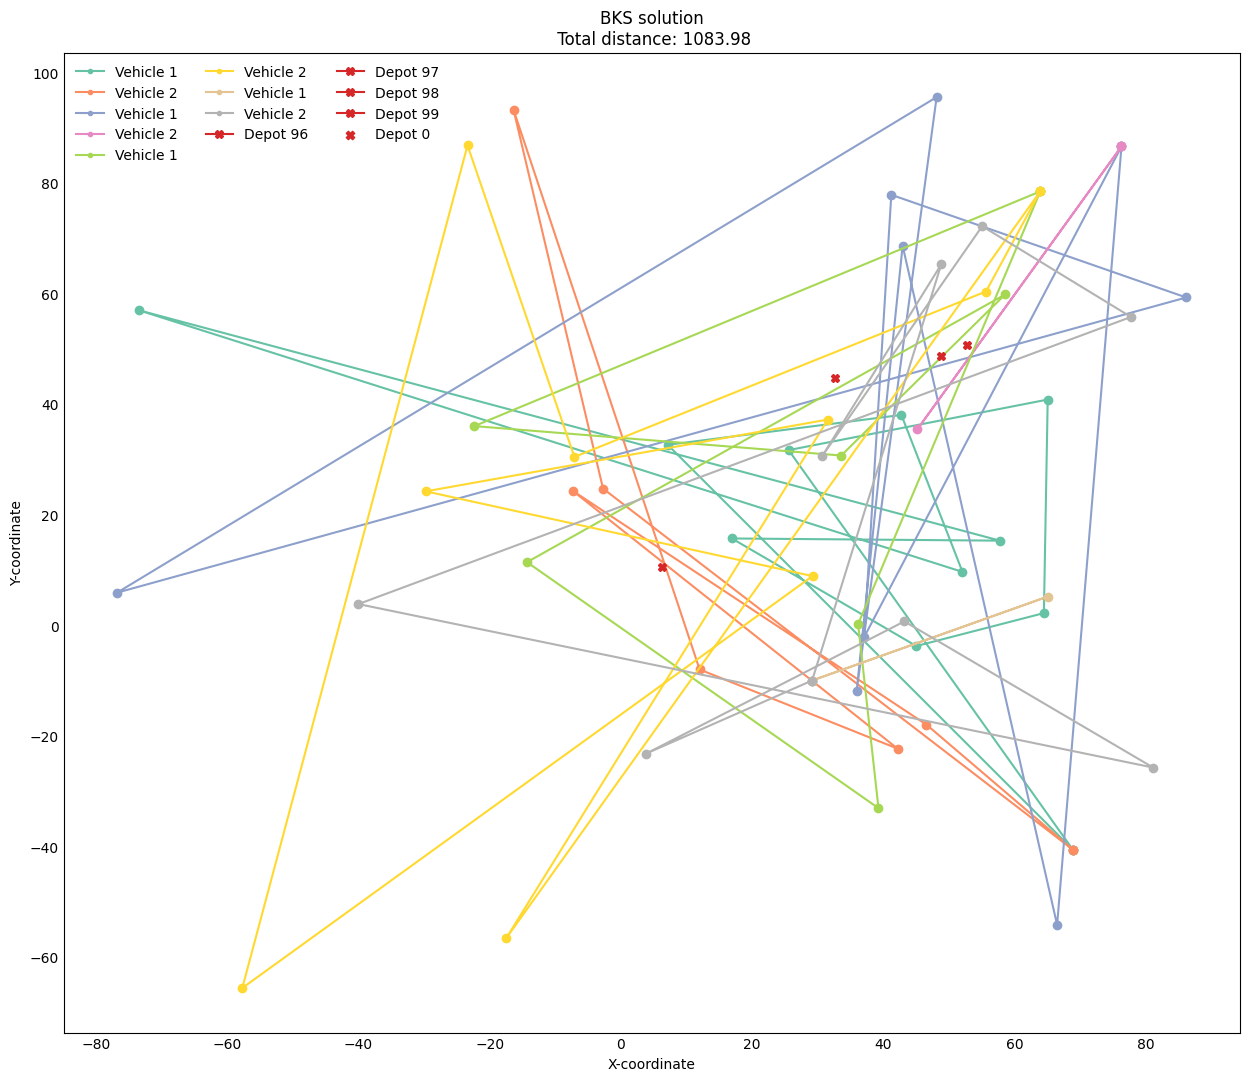

In [60]:
def plot_bks(data: dict, solution, name= "BKS", figsize=(12, 10), save=False):

    fig, ax = plt.subplots(figsize=figsize)
    cmap = plt.get_cmap("Set2", solution["n_vehicles"])
    cmap

    for idx, route in enumerate(solution["routes"]):
        ax.plot(
            [data["node_coord"][loc][0] for loc in route["customers"]],
            [data["node_coord"][loc][1] for loc in route["customers"]],
            color=cmap(idx),
            marker=".",
            label=f"Vehicle {route['vehicle']}",
        )
        for cust in route["customers"]:
            coords = data["node_coord"][cust]
            ax.plot(coords[0], coords[1], "o", c=cmap(idx))

    kwargs = dict(zorder=3, marker="X")

    for i in range(data["dimension"], data["dimension"] + data["n_depots"]):
        depot = data["node_coord"][i]
        ax.plot(depot[0], depot[1], c="tab:red", **kwargs, label=f"Depot {i}")

    ax.scatter(*data["node_coord"][0], c="tab:red", label="Depot 0", **kwargs)

    ax.set_title(f"{name}\n Total distance: {solution["solution_cost"]}")
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.legend(frameon=False, ncol=3)

    if save:
        plt.savefig(f"./plots/{name}.png")
        plt.close()

plot_bks(data, bks, "BKS solution",)

In [61]:
print(f"data['node_coord][0]: {data['node_coord'][0]}")

data['node_coord][0]: [None None]


In [62]:
print(bks)

{'solution_cost': 1083.98, 'routes': [{'day': 1, 'vehicle': 1, 'duration': 410.12, 'load': 131.0, 'customers': [49, 9, 42, 46, 39, 15, 25, 26, 23, 36, 32, 49], 'star_times': [0.0, 80.0, 115.35, 171.23, 246.09, 301.57, 332.83, 356.6, 378.0, 416.94, 456.0, 472.84]}, {'day': 1, 'vehicle': 2, 'duration': 179.98, 'load': 59.0, 'customers': [49, 35, 44, 31, 41, 7, 37, 49], 'star_times': [0.0, 159.0, 176.93, 200.0, 222.39, 248.75, 322.0, 332.14]}, {'day': 2, 'vehicle': 1, 'duration': 353.01, 'load': 119.0, 'customers': [50, 34, 10, 45, 6, 27, 3, 48, 11, 50], 'star_times': [0.0, 182.0, 195.18, 203.0, 231.8, 398.0, 440.24, 473.4, 510.1, 525.67]}, {'day': 2, 'vehicle': 2, 'duration': 47.42, 'load': 21.0, 'customers': [50, 22, 50], 'star_times': [0.0, 371.0, 406.21]}, {'day': 3, 'vehicle': 1, 'duration': 242.07, 'load': 63.0, 'customers': [51, 28, 4, 19, 14, 1, 16, 51], 'star_times': [0.0, 257.0, 279.91, 345.85, 414.07, 441.07, 460.75, 484.29]}, {'day': 3, 'vehicle': 2, 'duration': 480.13, 'load'